In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import io
import cv2

from glob import glob
from PIL import Image
import tensorflow 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [2]:
# reading data
data = glob('static/train_data/*')

In [3]:
# load images and store it in list after conversion
images = []
def read_img(data):
    for i in range(len(data)):
        img = cv2.imread(data[i])
        img = cv2.resize(img,(224,224))
        images.append(img)

In [4]:
read_img(data)

In [5]:
# converting it into numpy array
img_arr = np.asarray(images)
img_arr = img_arr.astype('float32')

# shape of data
img_arr.shape

(223, 224, 224, 3)

In [6]:
# pre-processing

# reshaping images into (224, 224, 1)
img_arr = img_arr.reshape(-1 , 224 ,224 , 1)

# shape of images
img_arr.shape

(669, 224, 224, 1)

In [7]:
# rescaling
img_max = np.max(img_arr)
img_arr = img_arr / img_max

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(img_arr ,img_arr , test_size = 0.2, random_state=49) 

In [9]:
# initialing some parameters
batch_size = 128
epochs = 10
channel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, channel))

In [48]:
# Encoder-decoder function

def auto_enc(input_img):
    # encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    encoder_last = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    # decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_last) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    dec = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return dec

In [49]:
# Model
model = Model(input_img, auto_enc(input_img))

In [50]:
# compile 
model.compile(loss='mean_squared_error', optimizer = 'adam')

# model looks like
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       7385

In [51]:
# training
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1, validation_data =(X_test, y_test))

Epoch 1/10
5/5 [==============================] - 61s 11s/step - loss: 0.1257 - val_loss: 0.1021
Epoch 2/10
5/5 [==============================] - 59s 12s/step - loss: 0.1011 - val_loss: 0.0768
Epoch 3/10
5/5 [==============================] - 57s 11s/step - loss: 0.0795 - val_loss: 0.0757
Epoch 4/10
5/5 [==============================] - 58s 11s/step - loss: 0.0757 - val_loss: 0.0667
Epoch 5/10
5/5 [==============================] - 62s 12s/step - loss: 0.0689 - val_loss: 0.0701
Epoch 6/10
5/5 [==============================] - 59s 11s/step - loss: 0.0717 - val_loss: 0.0651
Epoch 7/10
5/5 [==============================] - 61s 12s/step - loss: 0.0676 - val_loss: 0.0650
Epoch 8/10
5/5 [==============================] - 60s 11s/step - loss: 0.0664 - val_loss: 0.0625
Epoch 9/10
5/5 [==============================] - 61s 12s/step - loss: 0.0646 - val_loss: 0.0606
Epoch 10/10
5/5 [==============================] - 58s 11s/step - loss: 0.0627 - val_loss: 0.0594


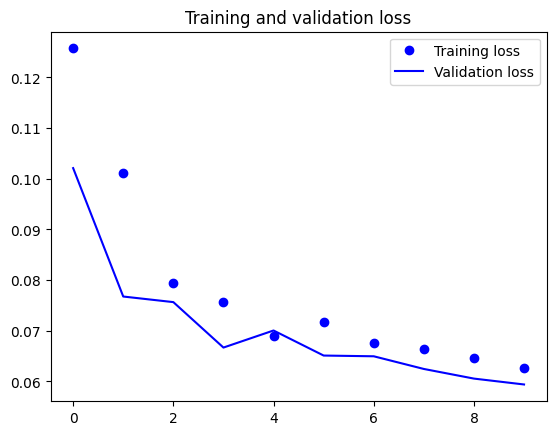

In [53]:
# validation and training loss graph

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [54]:
# prediction
y_pred = model.predict(X_test)

5/5 [==============================] - 2s 454ms/step


Test Images


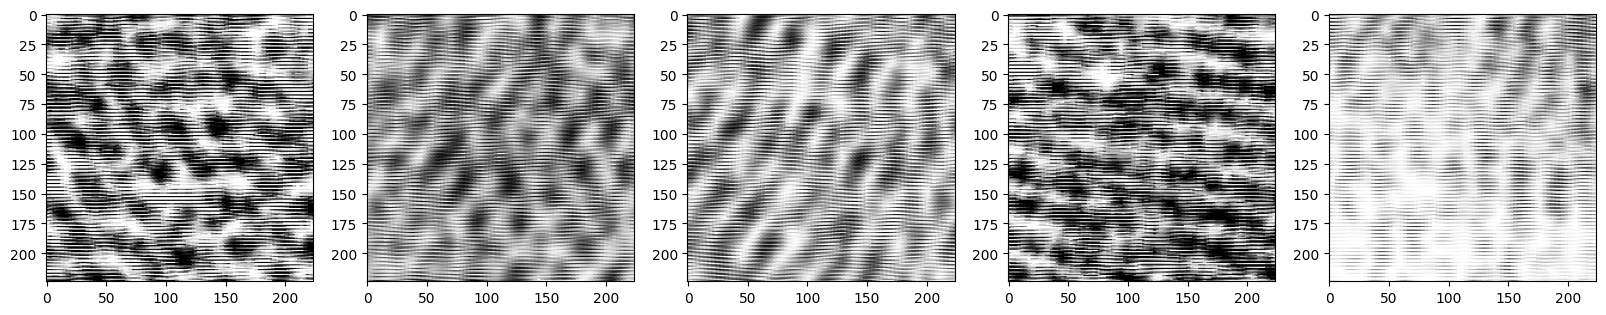

Reconstruction of Test Images


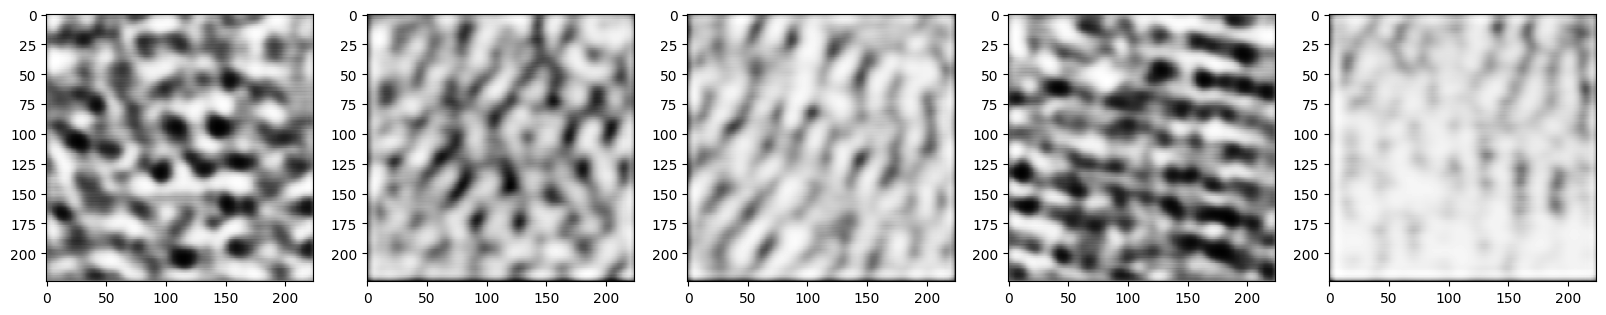

In [55]:
# visualization

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_test[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_pred[i, ..., 0], cmap='gray')  
    
plt.show()

In [34]:
# prediction on real data
new_data = glob('static/real_data/*')

In [35]:
# reading images
test_img = []
def read_images(new_data):
    for i in range(len(new_data)):
        img = cv2.imread(new_data[i])
        img = cv2.resize(img,(224,224))
        test_img.append(img)

In [36]:
read_images(new_data)

In [37]:
#  preprocessing
test_img = np.asarray(test_img)
test_img = test_img.astype('float32')

In [39]:
# shape of new_data
test_img.shape

(10, 224, 224, 3)

In [40]:
# scaling
test_img = test_img / np.max(test_img)

In [41]:
# reshaping as input for model
test_img = test_img.reshape(-1, 224,224, 1)
test_img.shape

(30, 224, 224, 1)

In [45]:
# prediction
y_pred_new = model.predict(test_img)

1/1 [==============================] - 1s 576ms/step


Test Real World Images


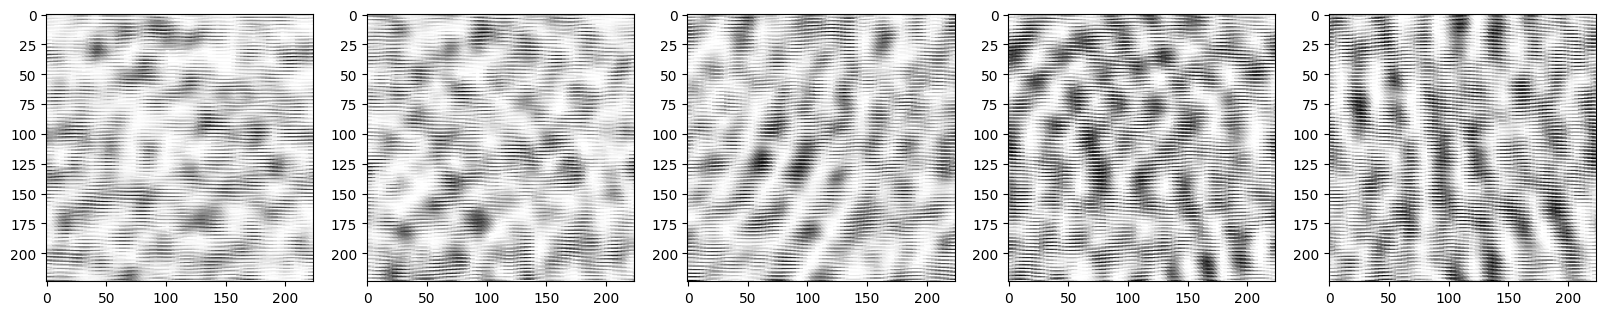

Reconstruction of Real World Images


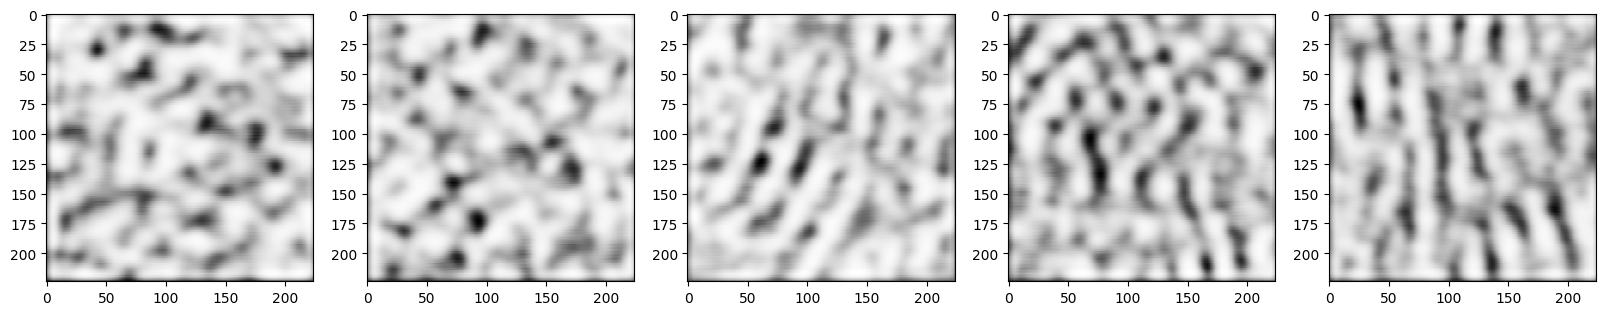

In [46]:
# visualization
plt.figure(figsize=(20, 4))
print("Test Real World Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_img[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Real World Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_pred_new[i, ..., 0], cmap='gray')  
plt.show()

In [69]:
import pickle

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))


In [69]:
import cv2
import numpy as np
import pickle
from PIL import Image

def predict(img):
    img = cv2.imread(img)
    img = cv2.resize(img,(224,224))

    img = np.asarray(img)
    img = img.astype('float32')

    img = img / np.max(img)

    img = img.reshape(-1, 224,224, 1)

    model = pickle.load(open("finalized_model.sav", 'rb'))
    res = model.predict(img)

    res = np.reshape(res, (224, 224, 3))

    res = (res * 255).astype(np.uint8)

    res = Image.fromarray(res)

    res.save('output_image.jpg')

In [70]:
predict('static/real_data/00000.bmp')

1/1 [==============================] - 0s 200ms/step
